In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import random 

sys.path.append('..')
from src.helpers import *
from implementations import *

DATA_PATH = '../data/train.csv'

In [4]:
def clean_data(x, mod):
    if mod == 'mean':
        mask = x == -999.0
        x[mask] = 0
        means = np.mean(x, axis=0, where=np.logical_not(mask))
        return x + np.tile(means, (x.shape[0],1))*mask
    
    elif mod == 'nn':
        pass


def normalize_data(x):
    normalized = (x-np.mean(x, axis=0))/np.std(x, axis=0)
    return normalized


def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.
        
    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.
    """
    # set seed
    np.random.seed(seed)
    
    idx = np.random.permutation(np.arange(len(x)))
    idx_max = np.floor(ratio*len(x)).astype(int)
    
    x_tr = x[idx][:idx_max]
    x_te = x[idx][idx_max:]
    y_tr = y[idx][:idx_max]
    y_te = y[idx][idx_max:]
    
    return x_tr, x_te, y_tr, y_te


def predict(x, w):
    y_pred = np.empty_like(x @ w)
    y_pred[sigmoid(x @ w)  > 0.5] = 1
    y_pred[sigmoid(x @ w) <= 0.5] = 0
    return y_pred


def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


def compute_f1_score(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_pred == y_true))
    fp = np.sum((y_pred == 1) & (y_pred != y_true))
    fn = np.sum((y_pred == 0) & (y_pred != y_true))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*(precision*recall)/(precision+recall)
    return f1_score


def plot_confusion_matrix():
    pass


def logistic_regression(y_tr, x_tr, y_te, x_te, initial_w, max_iters, gamma):
    """Logistic regression using GD

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,D)
        initial_w: numpy array of shape=(D, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        w: model parameters as numpy arrays of shape (D, )
        loss: log-loss value (scalar)
    """

    # Initialize weights and loss
    w = initial_w
    losses_tr = [compute_loss(y_tr, x_tr, w, "log")]
    losses_te = [compute_loss(y_te, x_te, w, "log")]
    acc_tr = [compute_accuracy(y_tr, predict(x_tr, w))]
    acc_te = [compute_accuracy(y_te, predict(x_te, w))]
    
    for i in range(max_iters):
        # compute gradient
        grad = compute_gradient(y_tr, x_tr, w, "log")

        # update w through the stochastic gradient update
        w = w - gamma * grad

        # calculate loss
        losses_tr.append(compute_loss(y_tr, x_tr, w, "log"))
        losses_te.append(compute_loss(y_te, x_te, w, "log"))
        
        acc_tr.append(compute_accuracy(y_tr, predict(x_tr, w)))
        acc_te.append(compute_accuracy(y_te, predict(x_te, w)))
        
    return w, losses_tr, losses_te, acc_tr, acc_te


def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    
    Args:
        x: numpy array of shape (N,D), N is the number of samples.
        degree: integer.
        
    Returns:
        poly: numpy array of shape (N,D*(degree+1))
    """
    
    poly = np.tile(x, (1,degree+1))
    poly = poly ** np.repeat(np.arange(degree+1), x.shape[1])
    
    return poly

# Load data

In [32]:
y, x, ids_train = load_csv_data(DATA_PATH, sub_sample=False)
y[y == -1] = 0

x = clean_data(x, mod="mean")
x = normalize_data(x)
x_tr, x_te, y_tr, y_te = split_data(x, y, ratio=0.75)

# Baseline (random guess)

In [33]:
y_pred = np.array([random.choice([-1, 1]) for i in range(y_te.shape[0])])

acc = compute_accuracy(y_te, y_pred)
f1 = compute_f1_score(y_te, y_pred)
print("Random guess achieves {:.2f} accuracy and {:.2f} F1 score on test set.".format(acc, f1))

Random guess achieves 0.17 accuracy and 0.51 F1 score on test set.


In [35]:
y_test, x_test, ids_test = load_csv_data('../data/test.csv', sub_sample=False)
y_pred = np.array([random.choice([-1, 1]) for i in range(y_test.shape[0])])
y_pred[y_pred == 0] = -1
create_csv_submission(ids_test, y_pred , 'submission.csv')

From Aircrowd, random guess 0.500 achieves accuracy and 0.406 F1-score.

# Run logistic regression using GD

In [36]:
max_iters = 100
gamma = 1

initial_w = np.random.uniform(-1, 1, size=x.shape[1])
w, losses_tr, losses_te, acc_tr, acc_te = logistic_regression(y_tr, x_tr, y_te, x_te, initial_w, max_iters, gamma)

### Plot loss and accuracy

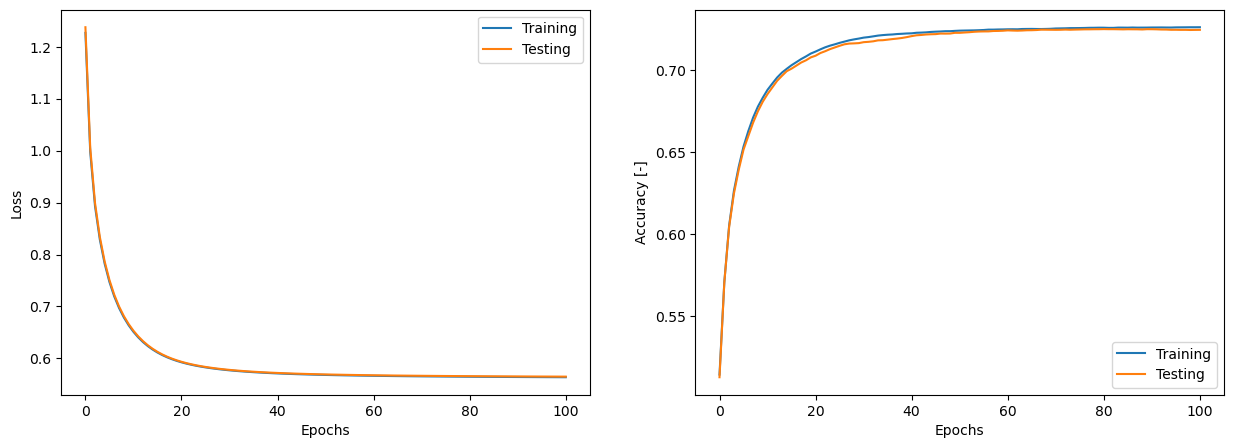

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses_tr)
ax1.plot(losses_te)
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend(["Training", "Testing"])

ax2.plot(acc_tr)
ax2.plot(acc_te)
ax2.set(xlabel='Epochs', ylabel='Accuracy [-]')
ax2.legend(["Training", "Testing"])

In [38]:
acc = compute_accuracy(y_te, predict(x_te, w))
f1 = compute_f1_score(y_te, predict(x_te, w))
print("Model achieves {:.4f} accuracy and {:.4f} F1 score on test set.".format(acc, f1))

Model achieves 0.7246 accuracy and 0.6655 F1 score on test set.


# Run logistic regression with polynomial expension

In [21]:
tx_tr = build_poly(x_tr, 2)
tx_te = build_poly(x_te, 2)

In [22]:
max_iters = 1000
gamma = 0.1

initial_w = np.random.uniform(-1, 1, size=tx_tr.shape[1])
w, losses_tr, losses_te, acc_tr, acc_te = logistic_regression(y_tr, tx_tr, y_te, tx_te, initial_w, max_iters, gamma)

### Plot loss and accuracy

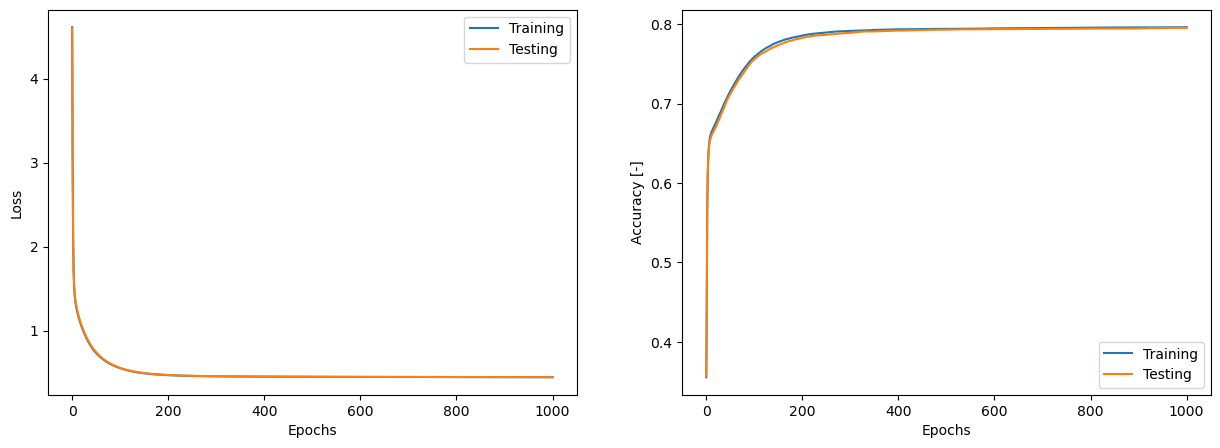

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses_tr)
ax1.plot(losses_te)
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend(["Training", "Testing"])

ax2.plot(acc_tr)
ax2.plot(acc_te)
ax2.set(xlabel='Epochs', ylabel='Accuracy [-]')
ax2.legend(["Training", "Testing"])

In [24]:
acc = compute_accuracy(y_te, predict(tx_te, w))
f1 = compute_f1_score(y_te, predict(tx_te, w))
print("Model achieves {:.4f} accuracy and {:.4f} F1 score on test set.".format(acc, f1))

Model achieves 0.7954 accuracy and 0.6784 F1 score on test set.


# Features augmentation, multiply every pair of feature:

In [15]:
from itertools import combinations

combs = list(combinations(range(x_tr.shape[1]),2))

tx_tr = np.zeros((x_tr.shape[0], x_tr.shape[1]+len(combs)))
tx_te = np.zeros((x_te.shape[0], x_te.shape[1]+len(combs)))

tx_tr[:,:x_tr.shape[1]] = x_tr
tx_te[:,:x_te.shape[1]] = x_te

for i, (col1, col2) in enumerate(combs):
    tx_tr[:,x_tr.shape[1]+i] = x_tr[:,col1]*x_tr[:,col2]
    tx_te[:,x_te.shape[1]+i] = x_te[:,col1]*x_te[:,col2]

tx_tr = np.concatenate((tx_tr, build_poly(x_tr, 2)), axis=1)
tx_te = np.concatenate((tx_te, build_poly(x_te, 2)), axis=1)

In [16]:
max_iters = 1000
gamma = 0.1

initial_w = np.random.uniform(-1, 1, size=tx_tr.shape[1])
w, losses_tr, losses_te, acc_tr, acc_te = logistic_regression(y_tr, tx_tr, y_te, tx_te, initial_w, max_iters, gamma)

/Users/tommery/Desktop/MA3/ML_project_1/notebooks/../implementations.py:210: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### Plot loss and accuracy

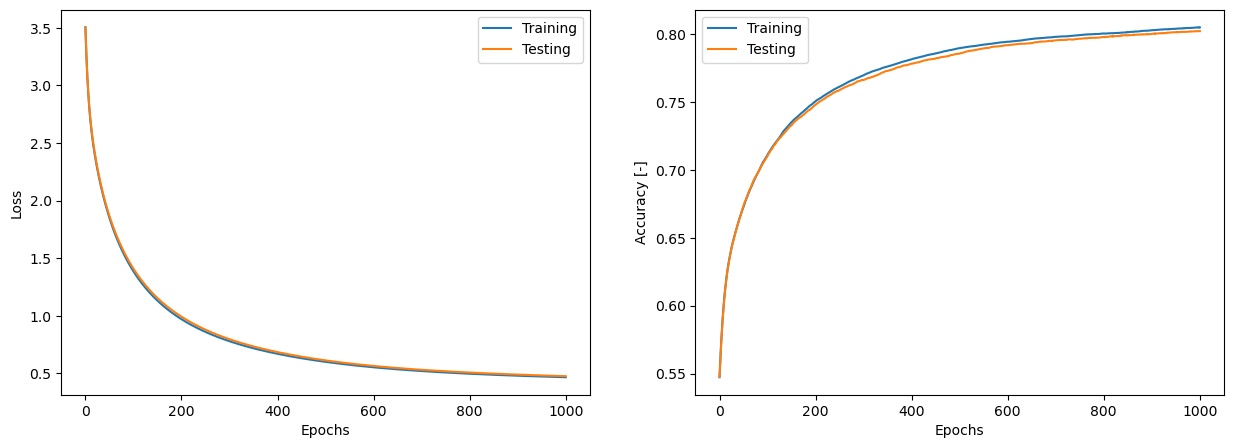

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses_tr)
ax1.plot(losses_te)
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.legend(["Training", "Testing"])

ax2.plot(acc_tr)
ax2.plot(acc_te)
ax2.set(xlabel='Epochs', ylabel='Accuracy [-]')
ax2.legend(["Training", "Testing"])

In [19]:
acc = compute_accuracy(y_te, predict(tx_te, w))
f1 = compute_f1_score(y_te, predict(tx_te, w))
print("Model achieves {:.4f} accuracy and {:.4f} F1 score on test set.".format(acc, f1))

Model achieves 0.8021 accuracy and 0.7027 F1 score on test set.
